# Mục Đích
> Trong phần này chúng ta sẽ cùng đi qua các phương thức để tạo được dataset của tensorflow, bao gồm:
> 1. Load dữ liệu có sẵn của tensorflow_datasets
> 2. Load dữ liệu từ folder
> 3. Load dữ liệu từ file excel

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__, keras.__version__

('2.4.1', '2.4.0')

## LOAD DATA ONLINE

### Sử dụng keras datasets

In [2]:
dir(keras.datasets)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'boston_housing',
 'cifar10',
 'cifar100',
 'fashion_mnist',
 'imdb',
 'mnist',
 'reuters']

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

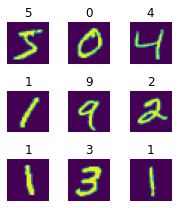

In [4]:
# Kiểm tra dữ liệu:
fig = plt.figure(figsize=(3, 3))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i,:])
    plt.title(y_train[i])
    plt.axis('off')
    plt.tight_layout()

In [5]:
# Biến đổi dữ liệu:
X_train = X_train/255
X_test = X_test/255

In [6]:
# Kiểm tra dữ liệu sau khi chia cho 225 (giá trị sẽ từ 0 đến 1)
X_train[1, 10:15, 10:15]

array([[0.93333333, 0.98823529, 0.98823529, 0.70196078, 0.04705882],
       [0.99215686, 0.91372549, 0.81568627, 0.32941176, 0.        ],
       [0.94117647, 0.27843137, 0.0745098 , 0.10980392, 0.        ],
       [0.24705882, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [7]:
# Normalize dữ liệu trước khi train, sử dụng mean và variance của imagenet:
# https://forums.fast.ai/t/is-normalizing-the-input-image-by-imagenet-mean-and-std-really-necessary/51338
normalizer = keras.layers.experimental.preprocessing.Normalization(mean=0.485, variance=0.229**2, name='normalize') 
X_train = normalizer(X_train)
X_test = normalizer(X_test)
X_train.shape, X_test.shape

(TensorShape([60000, 28, 28]), TensorShape([10000, 28, 28]))

In [8]:
# Kiểm tra dữ liệu sau khi normalize:
X_train[1, 10:15, 10:15]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 1.9577874 ,  2.1975338 ,  2.1975338 ,  0.94742703, -1.9124069 ],
       [ 2.2146587 ,  1.8721637 ,  1.4440448 , -0.67942464, -2.117904  ],
       [ 1.9920369 , -0.9020464 , -1.7925336 , -1.6384109 , -2.117904  ],
       [-1.0390445 , -2.117904  , -2.117904  , -2.117904  , -2.117904  ],
       [-2.117904  , -2.117904  , -2.117904  , -2.117904  , -2.117904  ]],
      dtype=float32)>

#### Tạo neural net cơ bản:

In [9]:
# Tạo neural net cơ bản:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='flatten'),
    keras.layers.Dense(128, activation='relu', name='layer1'),
    keras.layers.Dropout(.2, name='dropout'),
    keras.layers.Dense(20, activation='relu', name='layer2'),
    keras.layers.Dense(10, activation='softmax', name='predictions')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Đào tạo:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7460 - accuracy: 0.7609 - val_loss: 0.2212 - val_accuracy: 0.9361
Epoch 2/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2693 - accuracy: 0.9200 - val_loss: 0.1755 - val_accuracy: 0.9486
Epoch 3/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2263 - accuracy: 0.9353 - val_loss: 0.1567 - val_accuracy: 0.9566
Epoch 4/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2015 - accuracy: 0.9426 - val_loss: 0.1647 - val_accuracy: 0.9546
Epoch 5/5
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1769 - accuracy: 0.9477 - val_loss: 0.1562 - val_accuracy: 0.9593


**Lưu ý:** chúng ta sử dụng thêm normalizer để normalize dữ liệu thì kết quả metrics chưa thực sự rõ ràng, tuy nhiên loss được cải thiện tương đối.

#### Thay đổi tốc độ học:
> tốc độ học (learning rate) đi kèm với optimizer trong keras, nên muốn tác động vào lr, chúng ta có thể làm bằng 1 trong 2 cách sau:

_Chọn optimizer bằng method trong keras.optimizers_

In [11]:
# Learning rate (tốc độ học) đi kèm với optimizer. Chúng ta có thể tác động vào learning rate với keras.optimizers:
optimizer = keras.optimizers.RMSprop(learning_rate=3e-3)

_Hoặc sử dụng keras backends để sửa learning rate_

In [12]:
# Hoặc bằng cách sử dụng backend set_value method:
print('lr before: ', model.optimizer.learning_rate.numpy())
K.set_value(model.optimizer.learning_rate, 0.003)
print('lr after: ', model.optimizer.learning_rate.numpy())

lr before:  0.001
lr after:  0.003


#### Thay đổi hàm loss:
> hàm loss (hàm mất mát) cũng có thể được thay đổi tương tự như learning rate.

In [13]:
dir(keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'huber',
 'kl_divergence',
 'kld',
 'kullback_leibler_divergence',
 'log_cosh',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [16]:
# tạo hàm loss:
loss_func = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [46]:
# sửa hàm loss dùng backend.set_value:
# print('loss func before: ', model.loss)
# K.set_value(model.loss, keras.losses.categorical_crossentropy)
# print('loss func after: ', model.loss)

In [17]:
# Đào tạo lại
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2)

Epoch 1/2
1875/1875 [==============================] - 26s 13ms/step - loss: 0.9586 - accuracy: 0.7291 - val_loss: 0.2956 - val_accuracy: 0.9178
Epoch 2/2
1875/1875 [==============================] - 25s 14ms/step - loss: 0.3808 - accuracy: 0.8878 - val_loss: 0.2168 - val_accuracy: 0.9347


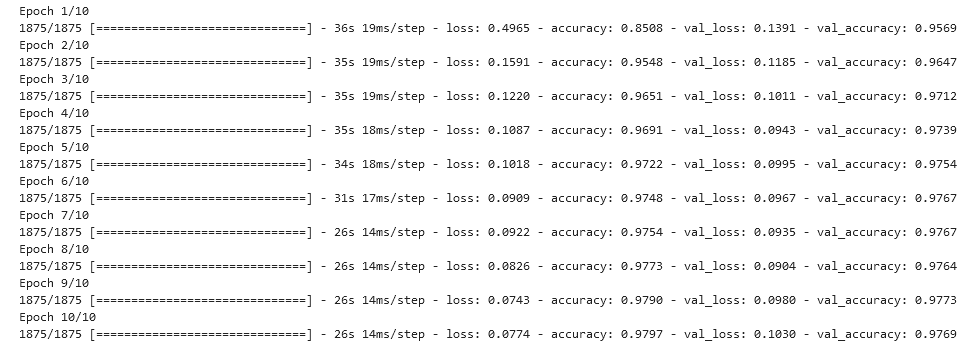


#### Thay đổi metrics
> Tương tự như lr và loss, chúng ta cũng có thể thay đổi metrics.

In [20]:
dir(keras.metrics)

['AUC',
 'Accuracy',
 'BinaryAccuracy',
 'BinaryCrossentropy',
 'CategoricalAccuracy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'FalseNegatives',
 'FalsePositives',
 'Hinge',
 'KLD',
 'KLDivergence',
 'LogCoshError',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'Mean',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanIoU',
 'MeanRelativeError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'MeanTensor',
 'Metric',
 'Poisson',
 'Precision',
 'PrecisionAtRecall',
 'Recall',
 'RecallAtPrecision',
 'RootMeanSquaredError',
 'SensitivityAtSpecificity',
 'SparseCategoricalAccuracy',
 'SparseCategoricalCrossentropy',
 'SparseTopKCategoricalAccuracy',
 'SpecificityAtSensitivity',
 'SquaredHinge',
 'Sum',
 'TopKCategoricalAccuracy',
 'TrueNegatives',
 'TruePositives',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_accuracy',
 'binary_crossentropy',
 'categorica

In [21]:
# precision = keras.metrics.Precision()
# recall = keras.metrics.Recall()

In [32]:
# Tạo hàm F1Score dự vào True Positive (TP), False Positive (FP) và False Negative (FN):
# def f1(y_true, y_pred):
#     # Tính True Positive:
#     TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     # Tính Actual Positve: TP + FN
#     TP_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
#     # Tính Predicted Positve: TP + FP
#     TP_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     return  (2 * TP)/(TP_FN + TP_FP + K.epsilon())

In [36]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
predictions (Dense)          (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32)

1875/1875 [==============================] - 25s 13ms/step - loss: 0.3410 - accuracy: 0.9063 - val_loss: 0.2042 - val_accuracy: 0.9461


### Sử dụng tensorflow_datasets

In [64]:
# Load dữ liệu train và valid:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=32)
# train_ds = tfds.load('mnist', split='train', shuffle_files=True)

In [59]:
# Kiểm tra loại dữ liệu của train_ds/valid_ds:
print(train_ds)
print(train_ds.take(1)) # take method cho chúng ta lấy dữ liệu của tập train theo số lương iterations

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<TakeDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [4]:
train_ds.__class__

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [5]:
# In index của iteration chúng ta lấy, và keys của images:
for _, images in train_ds.take(2).enumerate():
    print(_)
    print(images.keys())

tf.Tensor(0, shape=(), dtype=int64)
dict_keys(['image', 'label'])
tf.Tensor(1, shape=(), dtype=int64)
dict_keys(['image', 'label'])


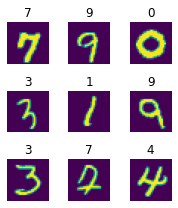

In [12]:
# Kiểm tra dữ liệu:
plt.figure(figsize=(3, 3))
for index, images in train_ds.take(1).enumerate():
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images['image'][i])
#         plt.title(images['label'][i].numpy())
        plt.title(np.int8(images['label'][i]))
        plt.axis("off")
        plt.tight_layout()

In [23]:
for index, images in train_ds.take(1).enumerate():
    print(tf.slice(images['image'][1], [10, 10, 0], [15, 15, 1]).numpy())
    if index > 0: break

[[[ 93]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 81]
  [252]
  [253]
  [150]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 32]
  [247]
  [253]
  [183]
  [  2]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  1]
  [109]
  [237]
  [253]
  [253]
  [249]
  [  5]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [110]
  [253]
  [253]
  [253]
  [253]
  [150]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [ 43]
  [110]
  [195]
  [250]
  [233]
  [167]
  [250]
  [253]
  [ 68]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[ 80]
  [243]
  [253]
  [241]
  [181]
  [ 53]
  [  7]
  [244]
  [253]
  [ 43]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[ 69]
  [199]
  [130]
  [ 20]
  [  0]
  [ 13]
  [177]
  [253]
  [240]
  [ 34]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 60]
  [253]
  [253]
  [188]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]


In [69]:
def divide_pixel(tensor):
    tensor['image'] = tf.cast(tensor['image'], tf.float32)/255.
    return tensor

In [70]:
train_ds = train_ds.map(divide_pixel)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [71]:
dir(tf.data.Dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name_b

#### Tạo neural net cơ bản:

In [7]:
dir(keras.models.Model)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_autographed_call',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compute_dtype',
 '_configure_steps_per_execution',
 '_dedup_weights',
 '_deferred_dependencies',
 '_dtype',
 '_eager_losses',
 '_flatten',
 '_flatten_

In [20]:
model = keras.Sequential()

In [21]:
model.add(keras.layers.Flatten(input_shape=(28, 28, 1), name='flatten'))
model.add(keras.layers.Dense(128, activation='relu', name='layer1'))
model.add(keras.layers.Dropout(0.5, name='dropout'))
model.add(keras.layers.Dense(20, activation='relu', name='layer2'))
model.add(keras.layers.Dense(10, activation='softmax', name='prediction'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 20)                2580      
_________________________________________________________________
prediction (Dense)           (None, 10)                210       
Total params: 103,270
Trainable params: 103,270
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Create optimizer and loss_fuction
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_func = keras.losses.SparseCategoricalCrossentropy()

In [43]:
model.compile(optimizer=optimizer, loss=loss_func, metrics='accuracy')

In [45]:
dir(keras.layers)

['AbstractRNNCell',
 'Activation',
 'ActivityRegularization',
 'Add',
 'AdditiveAttention',
 'AlphaDropout',
 'Attention',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv1DTranspose',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'Convolution1D',
 'Convolution1DTranspose',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Convolution3DTranspose',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'Dense',
 'DenseFeatures',
 'DepthwiseConv2D',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'GlobalMaxPooling2D',
 'Global

In [50]:
normalizer = keras.layers.experimental.preprocessing.Normalization(mean=0.485, variance=0.229**2, name='normalize')
for _, images in train_ds.enumerate():
    # divide to 255:
    images['image'] = images['image']/255
    images['image'] = normalizer(images['image'])
    model.fit(images['image'], images['label'], epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 21ms/step - loss: 0.9436 - accuracy: 0.7031
Epoch 2/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6678 - accuracy: 0.7031
Epoch 3/10
2/2 [==============================] - 0s 20ms/step - loss: 0.6774 - accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 0s 20ms/step - loss: 0.5289 - accuracy: 0.7812
Epoch 5/10
2/2 [==============================] - 0s 19ms/step - loss: 0.5682 - accuracy: 0.7812
Epoch 6/10
2/2 [==============================] - 0s 19ms/step - loss: 0.6875 - accuracy: 0.7812
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 0.7721 - accuracy: 0.7031
Epoch 8/10
2/2 [==============================] - 0s 17ms/step - loss: 0.6233 - accuracy: 0.7812
Epoch 9/10
2/2 [==============================] - 0s 18ms/step - loss: 0.4480 - accuracy: 0.8906
Epoch 10/10
2/2 [==============================] - 0s 20ms/step - loss: 0.5187 - accuracy: 0.7969
Epoch 1/10
2/2 [=============

KeyboardInterrupt: 

In [9]:
dir(tf.data.Dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name_b

In [10]:
?tf.data.Dataset.map

Signature:
tf.data.Dataset.map(
    self,
    map_func,
    num_parallel_calls=None,
    deterministic=None,
)
Docstring:
Maps `map_func` across the elements of this dataset.

This transformation applies `map_func` to each element of this dataset, and
returns a new dataset containing the transformed elements, in the same
order as they appeared in the input. `map_func` can be used to change both
the values and the structure of a dataset's elements. For example, adding 1
to each element, or projecting a subset of element components.

>>> dataset = Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
>>> dataset = dataset.map(lambda x: x + 1)
>>> list(dataset.as_numpy_iterator())
[2, 3, 4, 5, 6]

The input signature of `map_func` is determined by the structure of each
element in this dataset.

>>> dataset = Dataset.range(5)
>>> # `map_func` takes a single argument of type `tf.Tensor` with the same
>>> # shape and dtype.
>>> result = dataset.map(lambda x: x + 1)

>>> # Each element is a tuple cont

__Lưu ý:__ với tensorflow dataset, chúng ta muốn biến đổi dữ liệu cần áp dụng mapping với dữ liệu này, sử dụng phương pháp: `tf.data.Dataset.map`

Ở đây, tương tự như bài toán của keras.dataset, chúng ta sẽ cần biến dữ liệu về khoảng 0-1 rồi normalize lại dữ liệu:

In [12]:
# Tạo hàm chia:
def pixel_divide(tensor):
    return ()tensor[]

In [14]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_func',
 '_map_reso

In [18]:
?train_ds.element_spec

Type:        property
String form: <property object at 0x7f5cb122ae00>
Docstring:  
The type specification of an element of this dataset.

>>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
>>> dataset.element_spec
TensorSpec(shape=(), dtype=tf.int32, name=None)

Returns:
  A nested structure of `tf.TypeSpec` objects matching the structure of an
  element of this dataset and specifying the type of individual components.


In [17]:
train_ds = train_ds.apply(pixel_divide)

TypeError: 'MapDataset' object is not subscriptable

In [96]:
for index, images in train_ds.take(1).enumerate():
    print(tf.slice(images['image'][1], [10, 10, 0], [15, 15, 1]).numpy())
    if index > 0: break

[[[  0]
  [  0]
  [  0]
  [106]
  [212]
  [253]
  [254]
  [244]
  [ 90]
  [  7]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [ 51]
  [247]
  [253]
  [253]
  [254]
  [253]
  [253]
  [169]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [ 26]
  [239]
  [222]
  [118]
  [ 60]
  [214]
  [254]
  [254]
  [151]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [ 21]
  [ 13]
  [  0]
  [  0]
  [ 13]
  [161]
  [253]
  [222]
  [ 80]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 30]
  [213]
  [254]
  [228]
  [ 21]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 59]
  [254]
  [253]
  [113]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 26]
  [255]
  [254]
  [ 80]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [110]
  [254]
  [227]
  [ 21]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]


In [72]:
# Cách khác để có thể xem được hình ảnh:
# train_ds, info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
# tfds.show_examples(train_ds, info)

In [14]:
# Tạo một model đơn giản:
model_tf = keras.Sequential([
    keras.layers.Flatten(name='flatten', input_shape=(28, 28, 1)),
    keras.layers.Dense(250, activation='relu', name='layer1'), 
    keras.layers.Dropout(.5, name='dropout')
    keras.layers.Dense(10, activation='softmax', name='layer2')
])

In [18]:
model.compile(optimizer='rmsprop', loss='caterogical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 250)               196250    
_________________________________________________________________
layer2 (Dense)               (None, 10)                2510      
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_ds[0]

TypeError: '_OptionsDataset' object is not subscriptable

In [ ]:
# for index, images in train_ds.enumerate():
#     if index==0: 
#         ds_image = images['image']
#         ds_label = images['label']
#     ds_image = np.append(ds_image, images['image'])
#     ds_label = np.append(ds_label, images['label'])
# ds_image = tf.cast(np.reshape(ds_image, (-1, 28, 28, 1)), tf.int64)

In [20]:
model.fit(train_ds, batch_size=32, epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer sequential_4 expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(28, 28, 1) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=() dtype=int64>]


In [31]:
learn = keras.applications.resnet50.ResNet50(include_top=False)
learn.summary()

94773248/94765736 [==============================] - 12s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_________________________

Shape before:  (64, 28, 28, 1)
Shape after:  (64, 28, 28, 3)


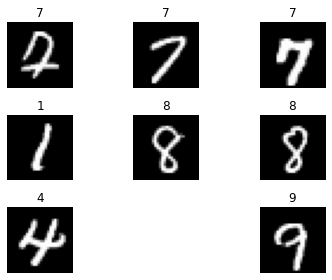

In [17]:
# Vì train_ds là dạng 1 channel (28, 28, 1), nên để sử dụng pretrained models vs keras, chúng ta phải biến đổi tập train thành dữ liệu dạng 3 channels:
for index, images in enumerate(train_ds.take(1)):
    print('Shape before: ', images['image'].shape)
    images['image'] = np.repeat(images['image'], 3, -1)
    print('Shape after: ', images['image'].shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images['image'][i])
        plt.title(images['label'][i].numpy())
        plt.axis("off")
        plt.tight_layout()

In [78]:
# print(grayscale_batch.shape)  # (64, 224, 224)    
# rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)    
# print(rgb_batch.shape)  # (64, 224, 224, 3)

['ResNet50',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'decode_predictions',
 'preprocess_input']

In [18]:
# Load dữ liệu train và valid:
train_ds, valid_ds = tfds.load('mnist', split=['train', 'test'])

In [24]:
for index, images in train_ds.enumerate():
    if index.numpy() == 0: 
        train_images = np.repeat(images['image'][...], 3, -1)
        train_labels = images['label'].numpy()
    print(train_images.shape)
    print(train_labels.shape)
    print(index)
    train_images = np.append(train_images, np.repeat(images['image'][...], 3, -1))
    train_labels = np.append(train_labels, images['label'].numpy())
    if index == 64: break

(28, 28, 3)
()
tf.Tensor(0, shape=(), dtype=int64)
(4704,)
(2,)
tf.Tensor(1, shape=(), dtype=int64)
(7056,)
(3,)
tf.Tensor(2, shape=(), dtype=int64)
(9408,)
(4,)
tf.Tensor(3, shape=(), dtype=int64)
(11760,)
(5,)
tf.Tensor(4, shape=(), dtype=int64)
(14112,)
(6,)
tf.Tensor(5, shape=(), dtype=int64)
(16464,)
(7,)
tf.Tensor(6, shape=(), dtype=int64)
(18816,)
(8,)
tf.Tensor(7, shape=(), dtype=int64)
(21168,)
(9,)
tf.Tensor(8, shape=(), dtype=int64)
(23520,)
(10,)
tf.Tensor(9, shape=(), dtype=int64)
(25872,)
(11,)
tf.Tensor(10, shape=(), dtype=int64)
(28224,)
(12,)
tf.Tensor(11, shape=(), dtype=int64)
(30576,)
(13,)
tf.Tensor(12, shape=(), dtype=int64)
(32928,)
(14,)
tf.Tensor(13, shape=(), dtype=int64)
(35280,)
(15,)
tf.Tensor(14, shape=(), dtype=int64)
(37632,)
(16,)
tf.Tensor(15, shape=(), dtype=int64)
(39984,)
(17,)
tf.Tensor(16, shape=(), dtype=int64)
(42336,)
(18,)
tf.Tensor(17, shape=(), dtype=int64)
(44688,)
(19,)
tf.Tensor(18, shape=(), dtype=int64)
(47040,)
(20,)
tf.Tensor(19, shap

In [25]:
train_images = np.reshape(train_images, (-1, 28, 28, 3))
train_images = tf.cast(train_images, tf.int64)

In [26]:
train_images.shape

TensorShape([66, 28, 28, 3])

In [27]:
dir(tf.data.Dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name_b

In [28]:
train_ds = tf.data.Dataset.from_tensor_slices(
    [train_images, train_labels]
)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [66,28,28,3] != values[1].shape = [66] [Op:Pack]

In [23]:
# Tạo learner:
learn = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(28, 28, 3))

ValueError: Input size must be at least 32x32; got `input_shape=(28, 28, 3)`